In [56]:
import torch
import math
from torch import nn

from PIL import Image
import torchvision.transforms as T
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from visualize_tools import get_pca_map
import numpy as np
import os
import random

In [57]:
def interpolate_pos_encoding(x, w, h):
    N = x.shape[1] - 1
    dim = x.shape[-1]
    w0 = w / int(math.sqrt(N))
    h0 = h / int(math.sqrt(N))

    # Interpolate the position embeddings without changing the first row (class token)
    patch_pos_embed = nn.functional.interpolate(
        x[:, 1:]
        .reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim)
        .permute(0, 3, 1, 2),
        scale_factor=(w0, h0),
        mode="bicubic",
    )

    # assert int(w0) == patch_pos_embed.shape[-2]
    # assert int(h0) == patch_pos_embed.shape[-1]
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)

    # Concatenate the class token with the interpolated position embeddings
    return torch.cat((x[:, :1], patch_pos_embed), dim=1)


def get_downloaded_dino_vit_interpolated(modelname="dinov2_vits14", pretrained=False):
    model = torch.hub.load(
        "facebookresearch/dinov2", modelname, pretrained=pretrained
    )  #
    input_tensor = model.pos_embed
    tensor_corr_shape = interpolate_pos_encoding(input_tensor, 16, 16)
    pos_embed = nn.Parameter(torch.zeros(1, 257))
    pos_embed.data = tensor_corr_shape
    model.pos_embed = pos_embed
    return model


In [64]:
IMAGE_PATH = "/bd_byta6000i0/users/sam2/wr/SU2024/cholec80/videos_1fps_frame/video51_1fps/114.png"
MASK_BASE_PATH = (
    "/bd_byta6000i0/users/surgicaldinov2/kyyang/segmentation_on_cholec80/masks"
)
DEPTH_BASE_PATH = "/bd_byta6000i0/users/surgicaldinov2/kyyang/Depth-Anything-V2/out"

In [65]:
converted_name = IMAGE_PATH.split("/")[-2] + "_" + IMAGE_PATH.split("/")[-1]
mask_path = os.path.join(MASK_BASE_PATH, converted_name)
depth_path = os.path.join(DEPTH_BASE_PATH, converted_name)

In [66]:
img = Image.open(IMAGE_PATH).convert("RGB")
mask_map = Image.open(mask_path).convert("L")
depth_map = Image.open(depth_path).convert("L")

In [67]:
def visualize_mask(img: Image, mask_map: Image, alpha: float = 0.8) -> Image:
    if img.mode != "RGBA":
        # 确保原图为RGBA格式，以便进行alpha混合
        img_rgba = img.convert("RGBA")
    else:
        img_rgba = img.copy()  # 在副本上操作

    if mask_map.mode != "L":
        # 确保掩码图为灰度图 ('L'模式)
        mask_map_l = mask_map.convert("L")
    else:
        mask_map_l = mask_map

    if img_rgba.size != mask_map_l.size:
        raise ValueError("图像和掩码的尺寸必须相同。")

    # 将掩码图转换为NumPy数组以便高效处理
    mask_array = np.array(mask_map_l)

    # 获取掩码中所有唯一的类别ID（非零值）
    unique_classes = sorted(np.unique(mask_array))

    # 为每个类别准备一个随机颜色
    # class_colors 字典将存储: {class_id: (R, G, B, Alpha_for_overlay)}
    class_colors = {}
    overlay_alpha_value = int(alpha * 255)  # 将0-1范围的alpha转换为0-255

    for class_id in unique_classes:
        if class_id == 0:  # 跳过背景类别（通常为0）
            continue
        class_colors[class_id] = (
            random.randint(30, 220),  # 随机R值 (避免纯黑或纯白)
            random.randint(30, 220),  # 随机G值
            random.randint(30, 220),  # 随机B值
            overlay_alpha_value,  # 指定的Alpha值
        )

    # 创建一个透明的叠加层，用于绘制各个类别的颜色
    colored_segments_overlay = Image.new("RGBA", img_rgba.size, (0, 0, 0, 0))

    # 为每个类别创建其颜色区域并粘贴到叠加层上
    for class_id, color_rgba in class_colors.items():
        # 1. 为当前类别创建一个二值掩码 (当前类别的像素为255，其他为0)
        #    这是告诉Pillow在哪里应用下面的颜色
        class_binary_mask_array = (mask_array == class_id).astype(np.uint8) * 255
        class_binary_mask_img = Image.fromarray(class_binary_mask_array, mode="L")

        # 2. 创建一个纯色的图像块，使用当前类别的指定颜色和透明度
        solid_color_for_class = Image.new("RGBA", img_rgba.size, color_rgba)

        # 3. 将这个纯色块根据二值掩码粘贴到总的彩色叠加层上
        #    `mask=class_binary_mask_img` 参数确保颜色只应用在类别所在区域
        colored_segments_overlay.paste(
            solid_color_for_class, (0, 0), mask=class_binary_mask_img
        )

    # 将包含所有彩色分类区域的叠加层与原始图像进行Alpha混合
    visualized_img = Image.alpha_composite(img_rgba, colored_segments_overlay)

    # 如果原始图像不是RGBA，可以转换回原始模式（例如RGB）
    # 如果原始是L模式，转换为RGB看起来更合适
    final_mode = img.mode if img.mode == "RGB" else "RGB"
    if img.mode == "L":  # 如果原图是灰度图，则显示为彩色叠加
        final_mode = "RGB"

    return visualized_img.convert(final_mode)

In [68]:
img_with_mask = visualize_mask(img, mask_map)

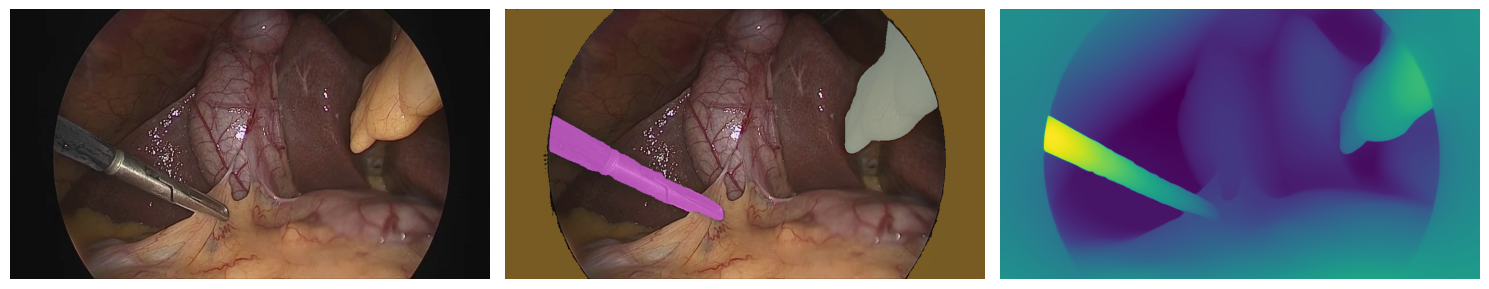

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[1].imshow(img_with_mask)
axes[2].imshow(depth_map)
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [70]:
trained_model = get_downloaded_dino_vit_interpolated("dinov2_vitl14")
trained_model.eval().to("cuda")

KeyboardInterrupt: 

In [71]:
transform = T.Compose(
    [
        T.Resize((476, 854), T.InterpolationMode.BICUBIC),
        T.CenterCrop((476, 854)),
        T.ToTensor(),
        # T.Normalize(mean=[0.5], std=[0.5]),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
raw_img = transform(img)[:3].unsqueeze(0).to("cuda")

In [72]:
LOCAL_WEIGHT_BASE_PATHS = [
    "/bd_byta6000i0/users/surgicaldinov2/kyyang/surgical_dinov2/vitl_train/only_depth/eval",
    "/bd_byta6000i0/users/surgicaldinov2/kyyang/surgical_dinov2/vitl_train/only_seg/eval",
    "/bd_byta6000i0/users/surgicaldinov2/kyyang/surgical_dinov2/vitl_train/seg_depth/eval",
]
MODEL_TYPE = "teacher"
START_INDEX = 499
END_INDEX = 2499
OUT_BASE_PATH = (
    "/bd_byta6000i0/users/surgicaldinov2/kyyang/surgical_dinov2/notebooks/results"
)

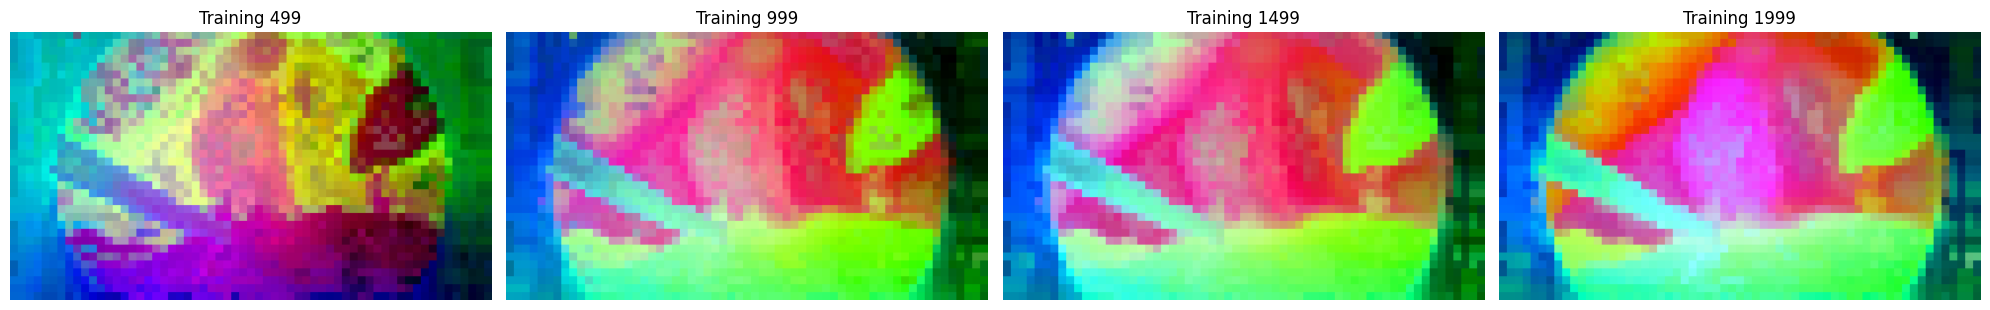

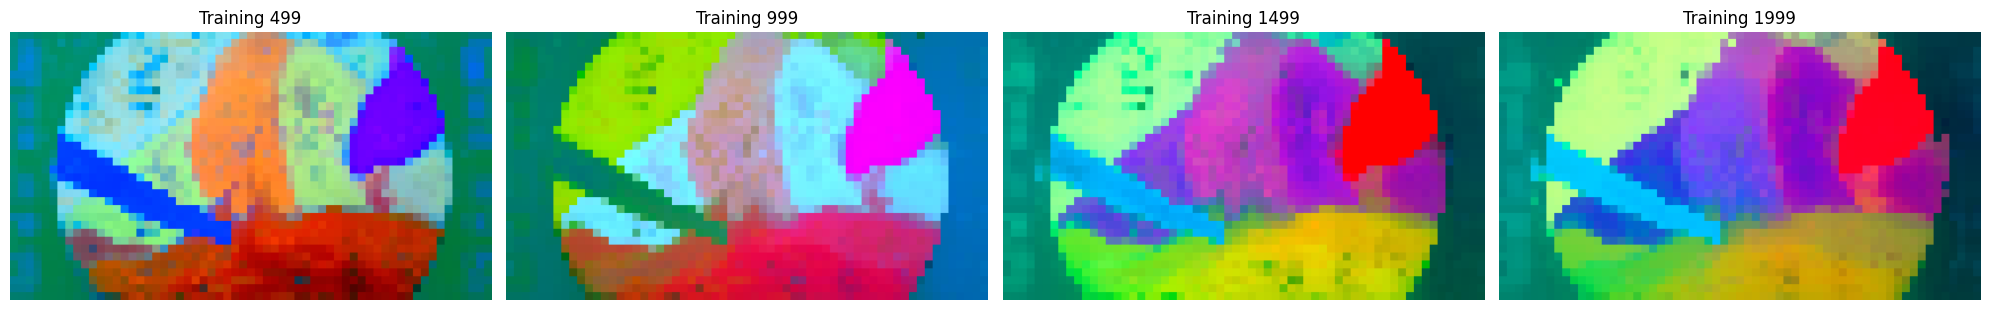

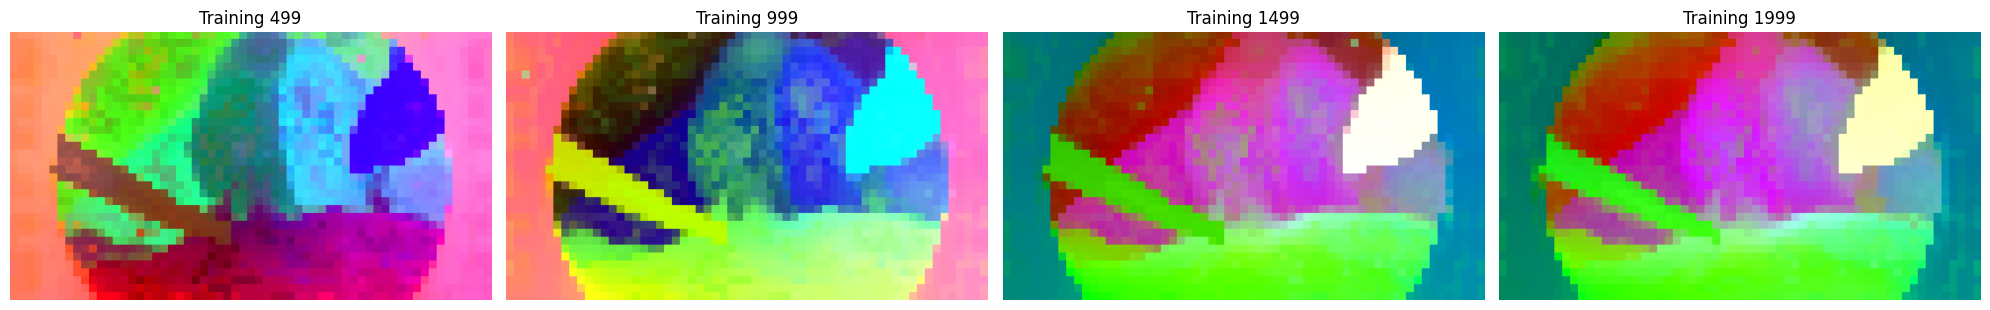

In [73]:
for local_weights_base_path in LOCAL_WEIGHT_BASE_PATHS:
    pca_imgs = []
    with torch.no_grad():
        for i in range(START_INDEX, END_INDEX, 500):
            local_weights_path = os.path.join(
                local_weights_base_path, f"training_{i}", f"{MODEL_TYPE}_checkpoint.pth"
            )
            state_dict = torch.load(
                local_weights_path, map_location=torch.device("cuda")
            )
            model_dict = {}
            for key, value in state_dict[MODEL_TYPE].items():
                if "backbone." in key:
                    model_dict[key.replace("backbone.", "")] = value
            trained_model.load_state_dict(model_dict)
            trained_model.eval().to("cuda")
            features = trained_model.forward_features(raw_img)
            raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)
            pca_img = get_pca_map(raw_features, img_size=(476, 854))
            pca_imgs.append(pca_img)

        num_imgs = len(pca_imgs)
        num_rows = (num_imgs + 3) // 4  # 每行5张，向上取整

        # 创建一个大图
        fig, axes = plt.subplots(num_rows, 4, figsize=(20, 3 * num_rows))

        # 绘制每个图像
        for i, ax in enumerate(axes.flatten()):
            if i < num_imgs:
                ax.imshow(pca_imgs[i])
                ax.set_title(f"Training {START_INDEX + i * 500}")
                ax.axis("off")
            else:
                ax.axis("off")  # 如果有空余的子图，关闭它们的轴

        training_name = local_weights_base_path.split("/")[-2]
        out_path = os.path.join(
            OUT_BASE_PATH,
            converted_name + "_" + training_name + "_" + MODEL_TYPE + "_pca.png",
        )
        plt.tight_layout()
        plt.savefig(out_path)
        plt.show()
